<a href="https://colab.research.google.com/github/RodriMenendez/BIO_LM_SURF/blob/main/Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Setup

In [54]:
!pip install wandb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 75.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.3/184.3 kB 25.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.4/209.4 kB 28.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 9.3 MB/s eta 0:00:00
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8791 sha256=b6e1d357fa0ad04d1610a52c8f8fc632a7e967e17c09542b5d2ab45022c42a31
  Stored in directory: /root/.cache/pip/wheels/e7/f3/22/152153d6eb222ee7a56ff8617d80ee5207207a8c00a7aab794
Successfully built pathtools


In [55]:
!wandb login

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [56]:
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torchsummary import summary

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import wandb

## Data Preprocessing

In [4]:
path = '/content/drive/MyDrive/SURF_2023/Practice'

transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
train_data = torchvision.datasets.CIFAR10(root=path+'/cifar10', train=True, transform=transform, download=True)

batch_size = 32
trainloader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

Files already downloaded and verified


In [47]:
test_data = torchvision.datasets.CIFAR10(root=path+'/cifar10', train=False, transform=transform, download=True)
testloader = torch.utils.data.DataLoader(test_data, batch_size=batch_size,
                                          shuffle=False, num_workers=2)

Files already downloaded and verified


In [6]:
classes = ['plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

## Image Example

Text(0.5, 1.0, 'plane')

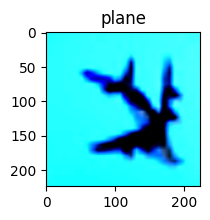

In [7]:
i = np.random.randint(0, high=len(train_data))

plt.figure(figsize=(2, 2))
plt.imshow(np.array(train_data[i][0]).T)
plt.title(classes[train_data[i][1]])

## RestNet tutorial
Link: https://pytorch.org/hub/pytorch_vision_resnet/ \
Downloding model and getting output

In [8]:
model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', weights='ResNet18_Weights.DEFAULT')

Downloading: "https://github.com/pytorch/vision/zipball/v0.10.0" to /root/.cache/torch/hub/v0.10.0.zip
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 270MB/s]


In [9]:
model = torchvision.models.resnet18(weights='DEFAULT')
# pre-trained model weights kept constant
for param in model.parameters():
    param.requires_grad = False

In [10]:
# Download ImageNet labels
!wget https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt

--2023-06-29 01:11:20--  https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10472 (10K) [text/plain]
Saving to: ‘imagenet_classes.txt’

imagenet_classes.tx 100%[===================>]  10.23K  --.-KB/s    in 0s      

2023-06-29 01:11:20 (96.4 MB/s) - ‘imagenet_classes.txt’ saved [10472/10472]



In [11]:
# Read the categories
with open("imagenet_classes.txt", "r") as f:
    categories = [s.strip() for s in f.readlines()]

In [12]:
j = np.random.randint(0, high=len(train_data))
test_probabilities = nn.functional.softmax(model(torch.reshape(train_data[j][0], (1, 3, 224, 224))), dim=1)

In [13]:
# Show top categories per image
top5_prob, top5_catid = torch.topk(test_probabilities, 10)
top5_catid = torch.reshape(top5_catid, (10,))
top5_prob = torch.reshape(top5_prob, (10,))

In [14]:
for i in range(top5_prob.size(0)):
    print(f'Category: {categories[top5_catid[i]]}\t\t', f'Probability: {top5_prob[i].item():.2}')

Category: bucket		 Probability: 0.0089
Category: hook		 Probability: 0.0066
Category: ashcan		 Probability: 0.0062
Category: plunger		 Probability: 0.0061
Category: water bottle		 Probability: 0.0057
Category: water jug		 Probability: 0.0056
Category: paper towel		 Probability: 0.0051
Category: ladle		 Probability: 0.0049
Category: cowboy hat		 Probability: 0.0046
Category: pole		 Probability: 0.0045


Text(0.5, 1.0, 'bird')

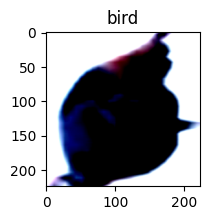

In [15]:
plt.figure(figsize=(2, 2))
plt.imshow(np.array(train_data[j][0]).T)
plt.title(classes[train_data[j][1]])

## Adding Classification Head

In [16]:
class Classification(nn.Module):
    def __init__(self, pretrained_model):
        super().__init__()
        self.pretrained_model = pretrained_model
        self.layer1 = nn.Linear(1000, 100)
        self.layer2 = nn.Linear(100, 10)

    def probabilities(self, x):
        output =  self.pretrained_model(x)
        output = F.relu(self.layer1(output))
        output = F.softmax(self.layer2(output), dim=1)

        return output

    def forward(self, x):
        output = self.probabilities(x)
        output = torch.argmax(output, dim=1)

        return output

In [17]:
clf_model = Classification(model)
if torch.cuda.is_available():
    clf_model.cuda()

In [18]:
test_data = torch.reshape(train_data[0][0], (1, 3, 224, 224))
if torch.cuda.is_available():
    test_data = test_data.cuda()

clf_model.probabilities(test_data)

tensor([[0.0732, 0.0869, 0.1172, 0.1165, 0.1011, 0.1423, 0.1380, 0.0648, 0.0844,
         0.0757]], device='cuda:0', grad_fn=<SoftmaxBackward0>)

In [19]:
from IPython.display import Javascript

display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 185})'''))
summary(clf_model, input_size=(3, 224, 224))

<IPython.core.display.Javascript object>

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

In [57]:
lr = 1e-5

loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(clf_model.parameters(), lr=lr)

In [59]:
def train_step(trainloader, model):
    correct = 0
    step_loss = 0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data

        if torch.cuda.is_available():
            inputs, labels = inputs.cuda(), labels.cuda()

        one_hot_labels = F.one_hot(labels, 10)

        # zero parameter gradients
        optimizer.zero_grad()

        # update values
        output = model.probabilities(inputs)
        loss = loss_func(output, one_hot_labels.float())
        step_loss += loss
        loss.backward()
        optimizer.step()

        # get classification accuracy
        accuracy_output = model(inputs)
        correct += (accuracy_output == labels).float().sum()

    step_loss /= len(trainloader)
    return step_loss, correct

def test_step(testloader, model):
    correct = 0
    for i, data in enumerate(testloader, 0):
        inputs, labels = data

        if torch.cuda.is_available():
            inputs, labels = inputs.cuda(), labels.cuda()

        output = model(inputs)

        correct += (output == labels).float().sum()

    return correct

In [62]:
epochs = 10

wandb.init(
    project = "CIFAR10-Resnet18-Classification",
    config={
        "learning rate": lr,
        "epochs": epochs,
        "dataset": "CIFAR10",
        "architecture": "Resnet18"
    }
)

for t in range(epochs):
    loss, train_correct = train_step(trainloader, clf_model)
    train_accuracy = train_correct/len(train_data)

    test_correct = test_step(testloader, clf_model)
    test_accuracy = test_correct/len(test_data)

    print(f'|Epoch: {t}\t|Loss: {loss:.3}\t|Train Accuracy: {train_accuracy:.3}\t|Test Accuracy: {test_accuracy:.3}')

    wandb.log({"train_acc": train_accuracy, "test_acc": test_accuracy, "loss": loss})

wandb: Currently logged in as: aavelarm (surf-2023). Use `wandb login --relogin` to force relogin


|Epoch: 0	|Loss: 2.2900655269622803	|Train Accuracy: 0.144	|Test Accuracy: 0.14800000190734863
|Epoch: 1	|Loss: 2.2884819507598877	|Train Accuracy: 0.151	|Test Accuracy: 0.15320000052452087
|Epoch: 2	|Loss: 2.2870194911956787	|Train Accuracy: 0.159	|Test Accuracy: 0.1615999937057495
|Epoch: 3	|Loss: 2.2854490280151367	|Train Accuracy: 0.166	|Test Accuracy: 0.16820000112056732
|Epoch: 4	|Loss: 2.283841609954834	|Train Accuracy: 0.172	|Test Accuracy: 0.17479999363422394
|Epoch: 5	|Loss: 2.2822494506835938	|Train Accuracy: 0.179	|Test Accuracy: 0.1824999898672104
|Epoch: 6	|Loss: 2.2804572582244873	|Train Accuracy: 0.186	|Test Accuracy: 0.1898999959230423
|Epoch: 7	|Loss: 2.278801679611206	|Train Accuracy: 0.193	|Test Accuracy: 0.19749999046325684
|Epoch: 8	|Loss: 2.2770988941192627	|Train Accuracy: 0.201	|Test Accuracy: 0.20479999482631683
|Epoch: 9	|Loss: 2.275408983230591	|Train Accuracy: 0.206	|Test Accuracy: 0.21169999241828918


In [63]:
wandb.finish()

loss,█▇▇▆▅▄▃▃▂▁
test_acc,▁▂▂▃▄▅▆▆▇█
train_acc,▁▂▃▃▄▅▆▆▇█
loss,2.27541
test_acc,0.2117
train_acc,0.20628


In [65]:
path = '/content/drive/MyDrive/SURF_2023/Practice/models/first_model'
torch.save(clf_model.state_dict(), path)

In [ ]:
## using model
# clf_model = Classification(model)
# clf_model.load_state_dict(torch.load(path))